# Estimación de ICI mediante histogramas de diagramas de constelación

## Librerías

In [1]:
import sofa

import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow.keras as ker
import json
import os

from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm

from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from itertools import product
from collections import defaultdict

2023-09-20 17:07:44.942660: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-20 17:07:44.987412: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 17:07:45.125834: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 17:07:45.126367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 17:07:46.018122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Funciones globales

### Extraer datos y calcular los histogramas

In [2]:
# Special function to read the known data structure
def read_data(folder_rx):
    data = {}

    # Read root directory
    for folder in os.listdir(folder_rx):
        # Check name consistency for subdirectories 
        if folder.endswith("spacing"):
            # Extract "pretty" part of the name
            spacing = folder[:-8]
            data[spacing] = {}
            
            # Read each data file
            for file in os.listdir(f"{folder_rx}/{folder}"):
                # Check name consistency for data files
                if file.find("consY") != -1:
                    # Extract "pretty" part of the name
                    osnr = file.split("_")[2][5:-4]
                    
                    # Initialize if not created yet
                    if data[spacing].get(osnr) == None:
                        data[spacing][osnr] = {}
                    # Set data
                    csv_file_data = pl.read_csv(f"{folder_rx}/{folder}/{file}")
                    data[spacing][osnr] = csv_file_data
    return data

def split(a, n):
    k, m = divmod(len(a), n)
    return np.array([a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n)])

def plot_constellation_diagram(X, ax):
    ax.scatter(X.real, X.imag, alpha=0.5)
    ax.set_title("Constellation diagram")
    ax.set_xlabel("I")
    ax.set_ylabel("Q")
    
def calculate_gmm(data, gm_kwargs):
    return GaussianMixture(**gm_kwargs).fit(data)
    
def calculate_1d_histogram(X, bins):
    hist_y, hist_x = np.histogram(X.real, bins=bins)
    # Remove last bin edge
    hist_x = hist_x[:-1]
    
    return hist_x, hist_y

def plot_1d_histogram(X, ax):
    ax.hist(X, bins=bins, density=True, alpha=0.5, label="Calculated histogram")
    
def plot_gmm_1d(gm, limits):
    x = np.linspace(*limits, 1000)
    
    logprob = gm.score_samples(x.reshape(-1, 1))
    responsibilities = gm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    
    ax.plot(x, pdf_individual, '--', label="Adjusted histogram")

def plot_gmm_2d(gm, limits, ax):
    x = y = np.linspace(*limits)
    X, Y = np.meshgrid(x, y)
    Z = -gm.score_samples(np.array([X.ravel(), Y.ravel()]).T).reshape(X.shape)

    ax.contour(
        X, Y, Z,
        norm=LogNorm(vmin=1.0, vmax=1000.0), 
        levels=np.logspace(0, 3, 25), cmap="seismic"
    )
    
def calculate_3d_histogram(X, bins, limits, spacing, snr):
    hist, xedges, yedges = np.histogram2d(X.real, X.imag, bins=bins, range=[[*limits], [*limits]])

    # Define the extent
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # Create the meshgrid for the surface plot, excluding the last edge
    x_mesh, y_mesh = np.meshgrid(xedges[:-1], yedges[:-1])
    
    return hist, x_mesh, y_mesh
    
def plot_3d_histogram(x_mesh, y_mesh, hist, ax):
    ax.plot_surface(x_mesh, y_mesh, hist.T, cmap="seismic", rstride=1, cstride=1, edgecolor="none")
    ax.set_title("3D Histogram")
    ax.set_xlabel("I")
    ax.set_ylabel("Q")

### Regresor

In [3]:
def calc_once(varname, fn, args):
    """ Calculate a variable only once. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)


def estimation_model(
    layers_props_lst: list, loss_fn: ker.losses.Loss, input_dim: int
) -> ker.models.Sequential:
    """ Compile a sequential model for regression purposes. """
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(input_dim=input_dim, **layer_props))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Regressor
    model.add(ker.layers.Dense(units=1, activation="linear"))
    
    model.compile(loss=loss_fn, optimizer="adam")
    
    return model


def estimation_crossvalidation(X, y, X_prod, y_prod, n_splits, layer_props, loss_fn, callbacks):
    """ Crossvalidation of an estimation network. """
    # Scores dict
    scores = {}
    scores["model"] = []
    scores["loss"] = []
    scores["mae"] = {"train": [], "test": [], "prod": []}
    scores["r2"] = {"train": [], "test": [], "prod": []}
    scores["rmse"] = {"train": [], "test": [], "prod": []}
    
    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)
        X_prod_kf = sc.transform(X_prod)

        model = estimation_model(layer_props, loss_fn, X_train.shape[1])
        
        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, callbacks=callbacks, verbose=0
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        loss = loss.history["loss"]
        
        # Predict using train values
        predictions_train = model.predict(X_train, verbose=0)
        # Predict using test values
        predictions_test = model.predict(X_test_kf, verbose=0)
        # Predict using production values
        predictions_prod = model.predict(X_prod_kf, verbose=0)

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )
        train_data_prod = pl.DataFrame(
            {"ICI": [y_prod], "Predicted ICI": [predictions_prod]}
        )

        # MAE
        mae_score_train = mean_absolute_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        mae_score_test = mean_absolute_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )
        mae_score_prod = mean_absolute_error(
            *train_data_prod["ICI"], *train_data_prod["Predicted ICI"]
        )

        # R²
        r2_score_train = r2_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        r2_score_test = r2_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )
        r2_score_prod = r2_score(
            *train_data_prod["ICI"], *train_data_prod["Predicted ICI"]
        )
         
        # RMSE
        rmse_score_train = mean_squared_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"],
            squared=False
        )
        rmse_score_test = mean_squared_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"],
            squared=False
        )
        rmse_score_prod = mean_squared_error(
            *train_data_prod["ICI"], *train_data_prod["Predicted ICI"],
            squared=False
        )

        # Append to lists
        scores["model"].append(model)
        scores["loss"].append(loss)
        scores["mae"]["train"].append(mae_score_train)
        scores["mae"]["test"].append(mae_score_test)
        scores["mae"]["prod"].append(mae_score_prod)
        scores["r2"]["train"].append(r2_score_train)
        scores["r2"]["test"].append(r2_score_test)
        scores["r2"]["prod"].append(r2_score_prod)
        scores["rmse"]["train"].append(rmse_score_train)
        scores["rmse"]["test"].append(rmse_score_test)
        scores["rmse"]["prod"].append(rmse_score_prod)
        
    return scores


def test_estimation_model(data, data_prod, n_splits, max_neurons, activations, 
                          use_osnr=True, loss_fn="mean_absolute_error"):
    """ Test a spectral spacing estimation model with given parameters. """
    n_feat = data.shape[1]
    var_n = n_feat - 1 if use_osnr else n_feat - 2

    # Split variables
    # Variables
    X = np.array(data[:, 0:var_n])
    X_prod = np.array(data_prod[:, 0:var_n])
    # Tags
    y = np.array(data[:, -1])
    y_prod = np.array(data_prod[:, -1])
    
    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(f"{layer_props}{' + OSNR' if use_osnr else ''}")
    callbacks = [
        EarlyStopping(monitor="loss", patience=30, mode="min", restore_best_weights=True)
    ]
    
    return estimation_crossvalidation(X, y, X_prod, y_prod, n_splits, layer_props, loss_fn, callbacks)

### Graficar resultados

In [4]:
def plot_results(x_values, scores, xlabel, log):
    plt.figure(figsize=(8, 6), layout="constrained")
    plt.scatter(x_values, scores)
    plt.plot(x_values, scores)
    plt.xlabel(xlabel)
    plt.ylabel("MAE")
    if log:
        plt.xscale("log", base=2)
    plt.grid(True)
    plt.show()

## Restaurar variables

In [5]:
%store -r histograms_hist
%store -r histograms_gmm
histograms = (histograms_hist, histograms_gmm)

## Leer datos

In [6]:
file_tx = "../../../Demodulation/Data/Processed/2x16QAM_16GBd.csv"
folder_rx = "../../../Demodulation/Data/Processed"

# Transmitted data
X_tx = np.array(pl.read_csv(file_tx))
X_txs = split(X_tx, 12)

# Read received data
data = read_data(folder_rx)

## Obtener histogramas

In [7]:
def get_histograms():
    spacings = ["15", "15.5", "16", "16.5", "17", "17.6", "18"]

    histograms_hist = defaultdict(lambda: defaultdict(list))
    histograms_gmm = defaultdict(lambda: defaultdict(list)) 
    bins = 128
    limits = [-5, 5]

    for spacing in spacings:
        X_rx = data[f"{spacing}GHz"]
        for snr in X_rx:
            # Extract data 
            X_ch = np.array(X_rx[snr])
            X_ch = X_ch[:, 0] + 1j*X_ch[:, 1]

            X_chs = split(X_ch, 12)

            for n, x_ch in enumerate(X_chs):
                # Calculate 2D GMM
                input_data = np.vstack((x_ch.real, x_ch.imag)).T
                gm_kwargs = {
                    "means_init": np.array(list(product([-3, -1, 1, 3], repeat=2))), 
                    "n_components": 16
                }
                gm_2d = calculate_gmm(input_data, gm_kwargs)

                # Calculate 3D histogram
                hist, x_mesh, y_mesh = calculate_3d_histogram(x_ch, bins, limits, spacing, snr)

                # Save 3D histogram
                histograms_hist[f"{spacing}GHz"][snr].append(hist)

                # Calculate I and Q histograms
                hist_x, hist_y = calculate_1d_histogram(x_ch.real, bins)
                input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
                gm_kwargs = {
                    "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1), 
                    "n_components": 4
                }
                gm_i = calculate_gmm(input_data, gm_kwargs)

                # Q
                hist_x, hist_y = calculate_1d_histogram(x_ch.imag, bins)
                input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
                gm_kwargs = {
                    "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1), 
                    "n_components": 4
                }
                gm_q = calculate_gmm(input_data, gm_kwargs)

                # Save gaussians
                histograms_gmm[f"{spacing}GHz"][snr].append([gm_2d, gm_i, gm_q])

    histograms_hist = dict(histograms_hist)
    histograms_gmm = dict(histograms_gmm)
    return histograms_hist, histograms_gmm

histograms = calc_once("histograms", get_histograms, {})
histograms_hist, histograms_gmm = histograms
%store histograms_hist
%store histograms_gmm

Stored 'histograms_hist' (dict)
Stored 'histograms_gmm' (dict)


In [8]:
def plot_histograms():
    spacings = ["15", "15.5", "16", "16.5", "17", "17.6", "18"]
    bins = 128
    limits = [-5, 5]
    
    for spacing in spacings:
        X_rx = data[f"{spacing}GHz"]
        for snr in X_rx:
            # Extract data 
            X_ch = np.array(X_rx[snr])
            X_ch = X_ch[:, 0] + 1j*X_ch[:, 1]
    
            plt.figure(figsize=(12, 12), layout="tight")
    
            # Plot constellation diagram
            ax = plt.subplot(2, 2, 1)
            plot_constellation_diagram(X_ch, ax)
            
            gm_2d = histograms_gmm.get(f"{spacing}GHz").get(snr)[0]
            
            # Plot 2D GMM
            plot_gmm_2d(gm_2d, limits, ax)
            ax.grid(True)
    
            # Calculate 3D histogram
            hist, x_mesh, y_mesh = calculate_3d_histogram(X_ch, bins, limits, spacing, snr)
            
            # Plot 3D histogram
            ax = plt.subplot(2, 2, 2, projection="3d")
            plot_3d_histogram(x_mesh, y_mesh, hist, ax)
    
            # Plot I and Q histograms separately
            # I
            ax = plt.subplot(2, 2, 3)
            plot_1d_histogram(X_ch.real, ax)
            
            hist_x, hist_y = calculate_1d_histogram(X_ch.real, bins)
            input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
            gm_kwargs = {
                "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1), 
                "n_components": 4
            }
            gm_i = calculate_gmm(input_data, gm_kwargs)
            plot_gmm_1d(gm_i, limits)
    
            ax.set_title("I-Histogram")
            ax.set_xlabel("I")
            ax.grid(True)
    
            # Q
            ax = plt.subplot(2, 2, 4)
            plot_1d_histogram(X_ch.imag, ax)
            
            hist_x, hist_y = calculate_1d_histogram(X_ch.imag, bins)
            input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
            gm_kwargs = {
                "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1), 
                "n_components": 4
            }
            gm_q = calculate_gmm(input_data, gm_kwargs)
            plot_gmm_1d(gm_q, limits)
            ax.set_title("Q-Histogram")
            ax.set_xlabel("Q")
            ax.grid(True)
        
            plt.suptitle(f"Plots for {snr} OSNR and {spacing}GHz of spacing")
    
            plt.show()

## Preparar datos

In [9]:
# Dataframe con 98 columnas
# 16 primeras para las medias
# 64 siguientes para los valores de las matrices de covarianza 
# (se incluyen las covarianzas repetidas)
# Penúltima para el valor del OSNR (dB)
# Última para el valor del espaciamiento (GHz)

n_features = 82
df_dict = {f"col{n}": [] for n in range(n_features)}
data_list = []

# Iterate over the dictionary and populate the DataFrame
for spacing, osnr_dict in histograms_gmm.items():
    for osnr, gmm_list in osnr_dict.items():
        for n in range(12):
            gmm_2d = gmm_list[n][0]
            means = gmm_2d.means_.flatten()
            covariances_raw = gmm_2d.covariances_.flatten()
            # Remove repeated covariances
            covariances = []
            for x, covariance in enumerate(covariances_raw):
                if x % 4 != 1:
                    covariances.append(covariance)
            osnr_value = np.array([float(osnr[:-2])])
            spacing_value = np.array([float(spacing[:-3])])

            features = np.concatenate((means, covariances, osnr_value, spacing_value))
            row_dict = {f"col{n}": feature for n, feature in enumerate(features)}
            data_list.append(row_dict)

# Convert the list of dictionaries into a DataFrame
df = pl.DataFrame(data_list)

# Print the DataFrame
df.write_json("histograms_features.json")

In [10]:
# Show the original dataframe
print(df)

shape: (840, 82)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────┬───────┐
│ col0      ┆ col1      ┆ col2      ┆ col3      ┆ … ┆ col78     ┆ col79    ┆ col80 ┆ col81 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---   ┆ ---   │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64   ┆ f64   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════╪═══════╡
│ -2.726003 ┆ -2.822036 ┆ -2.743914 ┆ -0.906839 ┆ … ┆ 0.006134  ┆ 0.247726 ┆ 23.0  ┆ 15.0  │
│ -2.707006 ┆ -2.735225 ┆ -2.773898 ┆ -0.827666 ┆ … ┆ -0.010791 ┆ 0.240321 ┆ 23.0  ┆ 15.0  │
│ -2.636324 ┆ -2.79119  ┆ -2.814175 ┆ -0.921746 ┆ … ┆ -0.014103 ┆ 0.244062 ┆ 23.0  ┆ 15.0  │
│ -2.735143 ┆ -2.759209 ┆ -2.714546 ┆ -0.934065 ┆ … ┆ 0.01472   ┆ 0.283967 ┆ 23.0  ┆ 15.0  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …        ┆ …     ┆ …     │
│ -2.685825 ┆ -2.698239 ┆ -2.743573 ┆ -0.789322 ┆ … ┆

In [11]:
# Shuffle the dataframe
df_shuffled = df.sample(n=len(df), shuffle=True, seed=1036681523)
print(df_shuffled)

shape: (840, 82)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────┬───────┐
│ col0      ┆ col1      ┆ col2      ┆ col3      ┆ … ┆ col78     ┆ col79    ┆ col80 ┆ col81 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---   ┆ ---   │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64   ┆ f64   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════╪═══════╡
│ -2.69468  ┆ -2.723298 ┆ -2.755449 ┆ -0.797507 ┆ … ┆ -0.00085  ┆ 0.070509 ┆ 30.0  ┆ 17.6  │
│ -2.680529 ┆ -2.716304 ┆ -2.735017 ┆ -0.773909 ┆ … ┆ -0.006771 ┆ 0.061365 ┆ 30.0  ┆ 18.0  │
│ -2.659728 ┆ -2.678015 ┆ -2.731777 ┆ -0.787159 ┆ … ┆ -0.00896  ┆ 0.165332 ┆ 40.0  ┆ 15.5  │
│ -2.680803 ┆ -2.711581 ┆ -2.763034 ┆ -0.876302 ┆ … ┆ -0.009641 ┆ 0.258689 ┆ 27.0  ┆ 15.0  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …        ┆ …     ┆ …     │
│ -2.685984 ┆ -2.684871 ┆ -2.711545 ┆ -0.818002 ┆ … ┆

In [12]:
# Extract 10% of the data to use later for "production" testing
df_prod = df_shuffled[:int(len(df_shuffled)*0.1)]
print(df_prod)

shape: (84, 82)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────┬───────┐
│ col0      ┆ col1      ┆ col2      ┆ col3      ┆ … ┆ col78     ┆ col79    ┆ col80 ┆ col81 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---   ┆ ---   │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64   ┆ f64   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════╪═══════╡
│ -2.69468  ┆ -2.723298 ┆ -2.755449 ┆ -0.797507 ┆ … ┆ -0.00085  ┆ 0.070509 ┆ 30.0  ┆ 17.6  │
│ -2.680529 ┆ -2.716304 ┆ -2.735017 ┆ -0.773909 ┆ … ┆ -0.006771 ┆ 0.061365 ┆ 30.0  ┆ 18.0  │
│ -2.659728 ┆ -2.678015 ┆ -2.731777 ┆ -0.787159 ┆ … ┆ -0.00896  ┆ 0.165332 ┆ 40.0  ┆ 15.5  │
│ -2.680803 ┆ -2.711581 ┆ -2.763034 ┆ -0.876302 ┆ … ┆ -0.009641 ┆ 0.258689 ┆ 27.0  ┆ 15.0  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …        ┆ …     ┆ …     │
│ -2.679546 ┆ -2.70241  ┆ -2.75939  ┆ -0.822979 ┆ … ┆ 

In [13]:
# Use the rest of the data for normal testing
df_new = df_shuffled[int(len(df_shuffled)*0.1):]
print(df_new)

shape: (756, 82)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────┬───────┐
│ col0      ┆ col1      ┆ col2      ┆ col3      ┆ … ┆ col78     ┆ col79    ┆ col80 ┆ col81 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---   ┆ ---   │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64   ┆ f64   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════╪═══════╡
│ -2.679268 ┆ -2.682966 ┆ -2.725179 ┆ -0.797204 ┆ … ┆ 0.01286   ┆ 0.165917 ┆ 21.5  ┆ 17.0  │
│ -2.656736 ┆ -2.702408 ┆ -2.763062 ┆ -0.883578 ┆ … ┆ -0.007773 ┆ 0.2314   ┆ 21.5  ┆ 15.5  │
│ -2.717137 ┆ -2.718527 ┆ -2.754985 ┆ -0.795125 ┆ … ┆ 0.003401  ┆ 0.072029 ┆ 30.0  ┆ 17.6  │
│ -2.653182 ┆ -2.692062 ┆ -2.787969 ┆ -0.847328 ┆ … ┆ 0.002211  ┆ 0.19236  ┆ 35.0  ┆ 15.0  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …        ┆ …     ┆ …     │
│ -2.685984 ┆ -2.684871 ┆ -2.711545 ┆ -0.818002 ┆ … ┆

## Evaluación de hiperparámetros

Se evaluará una combinación de parámetros:
- Número de neuronas máximas por capa (8, 16, 32, 64, 128, 256, 512, 1024).
- Número de capas (1, 2, 3).
- Combinación de funciones de activación (ReLu, tanh, sigmoid).
- El usar o no la OSNR como característica adicional.

Los resultados tendrán la siguiente estructura:
```
{"xyz": {"n_neurons": {"osnr/wo_osnr": results}}}
```
Donde xyz serán las iniciales de las combinaciones de funciones de activación, n_neurons será el número de neuronas máximo, osnr/wo_osnr será la indicación de si se usó o no el OSNR como característica y results será el objeto resultante que contiene todos los resultados.

In [14]:
osnr_lst = ["osnr", "wo_osnr"]
max_neurons = [str(2**n) for n in range(3, 11)]
functs = ["relu", "tanh", "sigmoid"]
layers_n = [1, 2, 3]

combinations = [
    [list(subset) for subset in product(functs, repeat=n)]
    for n in layers_n
]

hidden_layers = [item for sublist in combinations for item in sublist]

In [15]:
try:
    histograms_reg_results = sofa.load_hdf5("histograms_reg_results.h5")
except:
    print("Error loading from file, creating a new dictionary")
    histograms_reg_results = defaultdict(defaultdict(defaultdict(defaultdict().copy).copy).copy)

# Evaluar
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            args = {"data": df_new, "data_prod": df_prod, "n_splits": 5, "max_neurons": int(neurons), "activations": activations, "use_osnr": True if osnr == "osnr" else False}
            act_fn_name = "".join([s[0] for s in activations])
            if histograms_reg_results[act_fn_name][neurons][osnr] == defaultdict(): 
                # Get results
                results = test_estimation_model(**args)
                # Serialize model
                results["model"] = [utils.serialize_keras_object(model) for model in results["model"]]
                # Save serialized model for serialization
                histograms_reg_results[act_fn_name][neurons][osnr] = results
                # Save results with serialized model
                print("Saving results...")
                sofa.save_hdf5(histograms_reg_results, "histograms_reg_results.h5")
                print("Results saved!")

## Gráficas

### Número máximo de neuronas

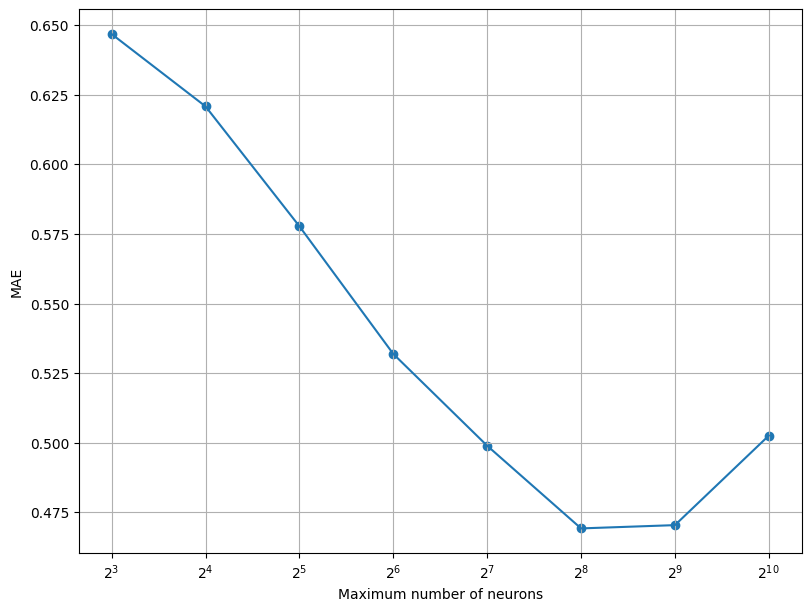

In [16]:
def get_test_mae_by_neurons(results, target_neurons):
    test_mae_lst = []
    for activations in hidden_layers:
        for neurons in max_neurons:
            if neurons != target_neurons:
                continue
            for osnr in osnr_lst:
                act_fn_name = "".join([s[0] for s in activations])
                test_mae_lst.append(np.mean(results[act_fn_name][neurons][osnr]["mae"]["test"]))
    return test_mae_lst
                
neurons_avg_results = [np.mean(get_test_mae_by_neurons(histograms_reg_results, neurons)) for neurons in max_neurons]
x = list(map(int, max_neurons))
plot_results(x, neurons_avg_results, "Maximum number of neurons", log=True)

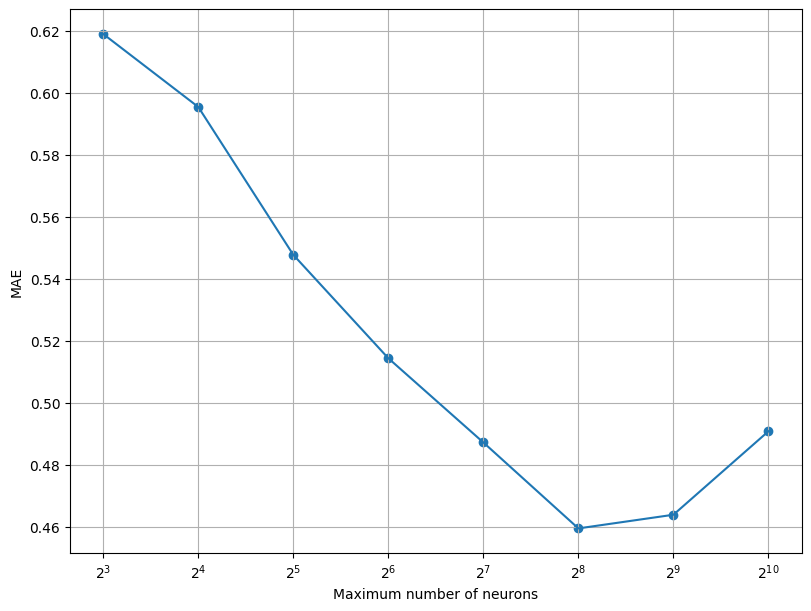

In [17]:
def get_test_mae_by_neurons(results, target_neurons):
    test_mae_lst = []
    for activations in hidden_layers:
        for neurons in max_neurons:
            if neurons != target_neurons:
                continue
            for osnr in osnr_lst:
                act_fn_name = "".join([s[0] for s in activations])
                test_mae_lst.append(np.mean(results[act_fn_name][neurons][osnr]["mae"]["prod"]))
    return test_mae_lst
                
neurons_avg_results = [np.mean(get_test_mae_by_neurons(histograms_reg_results, neurons)) for neurons in max_neurons]
x = list(map(int, max_neurons))
plot_results(x, neurons_avg_results, "Maximum number of neurons", log=True)

### Número de capas

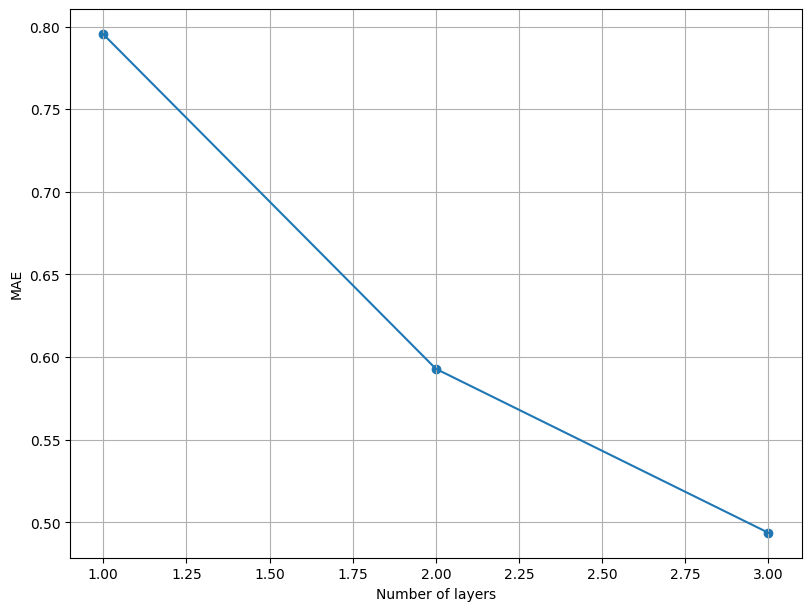

In [18]:
def get_test_mae_by_layers(results, target_layers):
    test_mae_lst = []
    for activations in hidden_layers:
        if len(activations) != target_layers:
            continue
        for neurons in max_neurons:
            for osnr in osnr_lst:
                act_fn_name = "".join([s[0] for s in activations])
                test_mae_lst.append(np.mean(results[act_fn_name][neurons][osnr]["mae"]["test"]))
    return test_mae_lst
                
layers_avg_results = [np.mean(get_test_mae_by_layers(histograms_reg_results, layers)) for layers in range(1, 4)]
x = range(1, 4)
plot_results(x, layers_avg_results, "Number of layers", log=False)

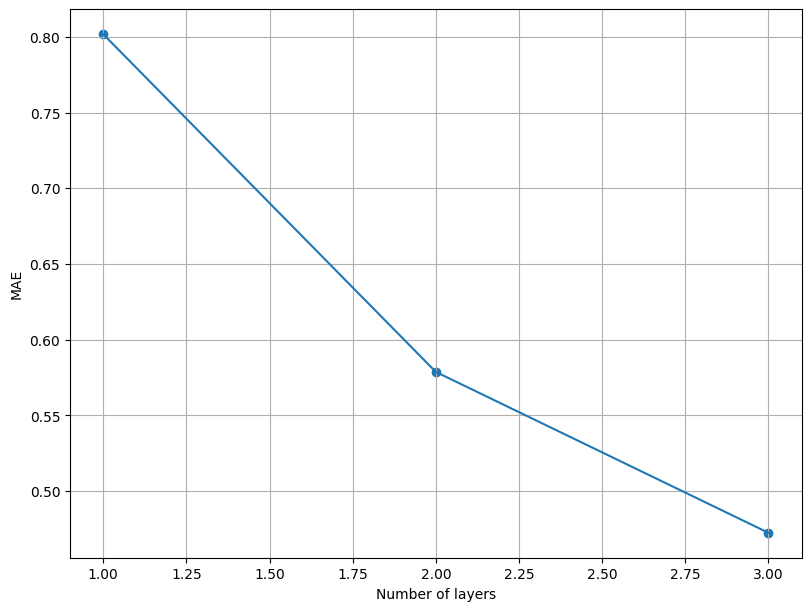

In [22]:
def get_test_mae_by_layers(results, target_layers):
    test_mae_lst = []
    for activations in hidden_layers:
        if len(activations) != target_layers:
            continue
        for neurons in max_neurons:
            for osnr in osnr_lst:
                act_fn_name = "".join([s[0] for s in activations])
                test_mae_lst.append(np.mean(results[act_fn_name][neurons][osnr]["mae"]["prod"]))
    return test_mae_lst
                
layers_avg_results = [np.mean(get_test_mae_by_layers(histograms_reg_results, layers)) for layers in range(1, 4)]
x = range(1, 4)
plot_results(x, layers_avg_results, "Number of layers", log=False)

### OSNR como característica opcional

In [23]:
def get_test_mae_by_osnr(results, target_osnr):
    test_mae_lst = []
    for activations in hidden_layers:
        for neurons in max_neurons:
            for osnr in osnr_lst:
                if osnr != target_osnr:
                    continue
                act_fn_name = "".join([s[0] for s in activations])
                test_mae_lst.append(np.mean(results[act_fn_name][neurons][osnr]["mae"]["test"]))
    return test_mae_lst
                
osnr_avg_results = [np.mean(get_test_mae_by_osnr(histograms_reg_results, osnr)) for osnr in ["osnr", "wo_osnr"]]
print(f"Con OSNR  Sin OSNR")
print(f"{osnr_avg_results[0]:.3f}       {osnr_avg_results[1]:.3f}")

Con OSNR  Sin OSNR
0.517       0.562


## Ordenar modelos por puntaje

In [24]:
# Find better model by test score
scores = []
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            act_fn_name = "".join([s[0] for s in activations])
            score = np.mean(histograms_reg_results[act_fn_name][neurons][osnr]["mae"]["test"])
            scores.append((score, [act_fn_name, neurons, osnr]))
scores.sort(key=lambda x: x[0])
better_models_df = pl.dataframe.DataFrame(scores)
better_models_df.head(25)

column_0,column_1
f64,list[str]
0.277249,"[""tts"", ""512"", ""osnr""]"
0.279191,"[""srt"", ""1024"", ""osnr""]"
0.279408,"[""srt"", ""256"", ""osnr""]"
0.280199,"[""stt"", ""1024"", ""osnr""]"
0.281659,"[""stt"", ""512"", ""osnr""]"
0.283932,"[""ttt"", ""512"", ""osnr""]"
0.28523,"[""st"", ""1024"", ""osnr""]"
0.287078,"[""tss"", ""1024"", ""osnr""]"
0.287834,"[""tss"", ""512"", ""osnr""]"


In [26]:
# Find better model by production score
scores = []
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            act_fn_name = "".join([s[0] for s in activations])
            score = np.mean(histograms_reg_results[act_fn_name][neurons][osnr]["mae"]["prod"])
            scores.append((score, [act_fn_name, neurons, osnr]))
scores.sort(key=lambda x: x[0])
better_models_df = pl.dataframe.DataFrame(scores)
better_models_df.head(25)

column_0,column_1
f64,list[str]
0.260126,"[""tss"", ""1024"", ""osnr""]"
0.261832,"[""tss"", ""512"", ""osnr""]"
0.263834,"[""ttt"", ""512"", ""osnr""]"
0.264236,"[""trs"", ""1024"", ""osnr""]"
0.265325,"[""tss"", ""256"", ""osnr""]"
0.266947,"[""tts"", ""1024"", ""osnr""]"
0.27022,"[""tst"", ""256"", ""osnr""]"
0.272026,"[""rrs"", ""512"", ""osnr""]"
0.272506,"[""rtt"", ""1024"", ""osnr""]"
